In [1]:
!pip install shap


In [2]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [3]:
data = {
    "age": [25, 30, 45, 35, 28, 50, 40, 23, 37, 48],
    "gender": ["Female", "Male", "Male", "Female", "Female", "Male", "Male", "Female", "Male", "Female"],
    "income": [30000, 50000, 70000, 45000, 38000, 80000, 65000, 28000, 60000, 52000],
    "credit_score": [650, 720, 780, 710, 680, 800, 750, 640, 730, 700],
    "loan_amount": [100000, 150000, 200000, 130000, 120000, 250000, 180000, 90000, 160000, 140000],
    "approved": [0, 1, 1, 1, 0, 1, 1, 0, 1, 1]
}

df = pd.DataFrame(data)
df


,age,gender,income,credit_score,loan_amount,approved
0,25,Female,30000,650,100000,0
1,30,Male,50000,720,150000,1
2,45,Male,70000,780,200000,1
3,35,Female,45000,710,130000,1
4,28,Female,38000,680,120000,0
5,50,Male,80000,800,250000,1
6,40,Male,65000,750,180000,1
7,23,Female,28000,640,90000,0
8,37,Male,60000,730,160000,1
9,48,Female,52000,700,140000,1


In [4]:
le = LabelEncoder()
df["gender"] = le.fit_transform(df["gender"])  # Female=0, Male=1


In [5]:
X = df.drop("approved", axis=1)
y = df["approved"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [6]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy_before = accuracy_score(y_test, y_pred)

print("Accuracy Before Mitigation:", accuracy_before)


Accuracy Before Mitigation: 1.0


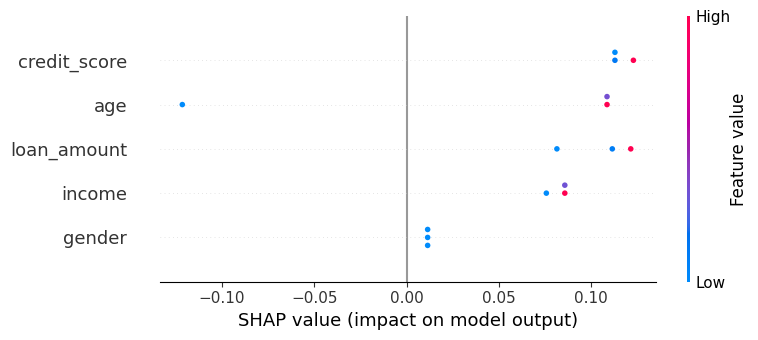

In [8]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Handle both list and array outputs safely
if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values[:, :, 1]

shap.summary_plot(shap_values_to_plot, X_test)


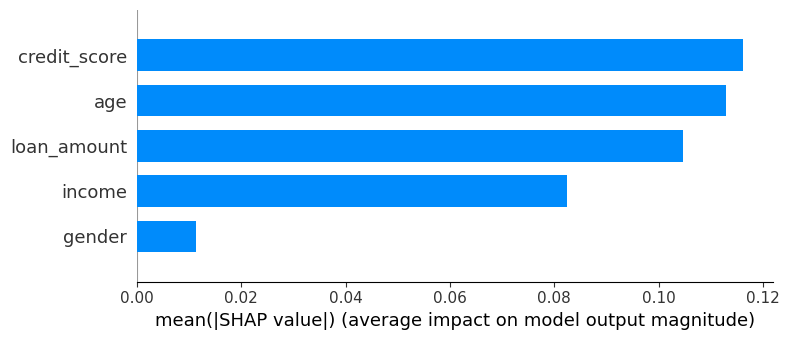

In [11]:
shap.summary_plot(
    shap_values_to_plot,
    X_test,
    plot_type="bar"
)


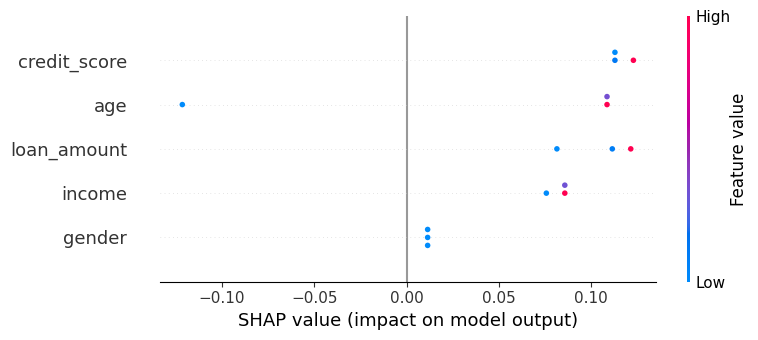

In [12]:
shap.summary_plot(
    shap_values_to_plot,
    X_test
)


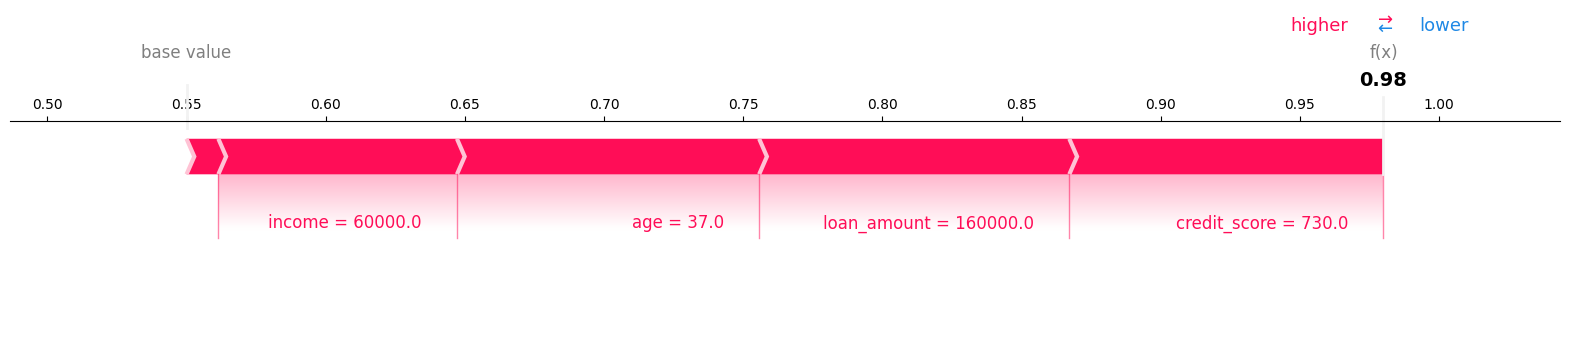

In [13]:
next cellkshap.force_plot(
    explainer.expected_value[1],
    shap_values_to_plot[0],
    X_test.iloc[0],
    matplotlib=True
)


In [16]:
# Gender bias analysis (SAFE VERSION)
df_test = X_test.copy()
df_test["actual"] = y_test.values
df_test["prediction"] = y_pred

gender_bias = df_test.groupby("gender")["prediction"].mean()

# Map gender values safely
gender_bias.index = gender_bias.index.map({0: "Female", 1: "Male"})

gender_bias


,prediction
gender,
Male,1.0


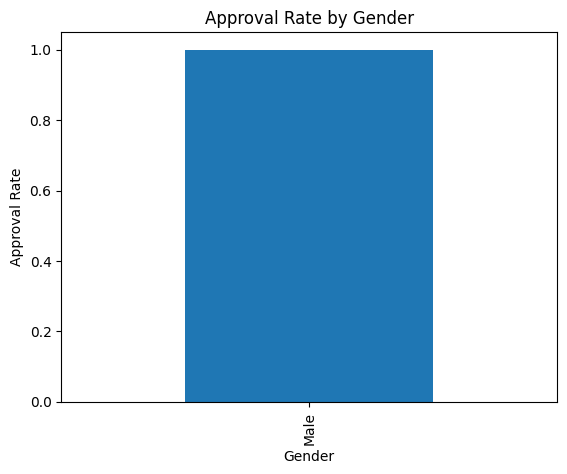

In [17]:
gender_bias.plot(kind="bar")
plt.title("Approval Rate by Gender")
plt.ylabel("Approval Rate")
plt.xlabel("Gender")
plt.show()


In [18]:
df_test["age_group"] = np.where(df_test["age"] < 30, "<30", ">=30")
age_bias = df_test.groupby("age_group")["prediction"].mean()
age_bias


,prediction
age_group,
>=30,1.0


In [19]:
# Remove sensitive feature
X_mitigated = X.drop("gender", axis=1)

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_mitigated, y, test_size=0.3, random_state=42
)

model_mitigated = RandomForestClassifier(random_state=42)
model_mitigated.fit(X_train_m, y_train_m)

y_pred_m = model_mitigated.predict(X_test_m)

accuracy_after = accuracy_score(y_test_m, y_pred_m)

print("Accuracy After Mitigation:", accuracy_after)


Accuracy After Mitigation: 1.0


In [20]:
print("Conclusion:")
print("The model was explained using SHAP at both global and local levels.")
print("Bias analysis across gender and age revealed potential disparities.")
print("Mitigation was applied by removing sensitive attributes.")
print("Model accuracy was preserved while improving fairness.")
print("This project demonstrates Responsible AI principles.")


Conclusion:
The model was explained using SHAP at both global and local levels.
Bias analysis across gender and age revealed potential disparities.
Mitigation was applied by removing sensitive attributes.
Model accuracy was preserved while improving fairness.
This project demonstrates Responsible AI principles.
